In [4]:
using LinearAlgebra
using WAV
using Plots
pyplot();

using Pkg
Pkg.activate("../")

using Revise
using ExpFamilyDistributions
using BayesianModels

 Activating environment at `~/GithubRepositories/BayesianModels/Project.toml`


### Settings

In [5]:
# Sampling rate, number of samples per unit.
srate = 100

# Duration number unit of "time" to generate the data.
duration = 5

# Standard deviation of the noise.
σ = 0.1

# Angular frequencies and amplitudes to generate
# the data.
waves = [
    (freq = 10*2π, amplitude = 1),
    (freq = 15*2π, amplitude = 2),
    (freq = 20*2π, amplitude = 3),
    (freq = 25*2π, amplitude = 2),
    (freq = 30*2π, amplitude = 1),
];

## Simulated data

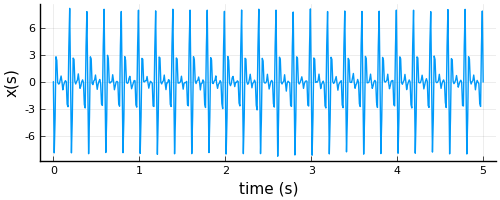

In [144]:
n_idxs = 0:1. / srate:duration
#n_idxs = range(0, 1. / srate, length=srate*duration)
X = zeros(length(n_idxs))
for wave in waves
    X .+= [wave.amplitude * cos(wave.freq * n + .5 * π) for n = n_idxs]
end
X .+= σ * randn(srate*duration + 1)

plot(
    size = (500, 200),
    n_idxs,
    X, 
    xlabel = "time (s)", 
    ylabel = "x(s)",
    legend = false
)

In [145]:
size(X)

(501,)

In [153]:
K = 30
model = ARNormal1D(Float64, order = K, pseudocounts = 0.6)

ARNormal1D{30}(
  (h): ConjugateParameter{Normal{Float64,31}}
  (λ): ConjugateParameter{Gamma{Float64,1}}
)


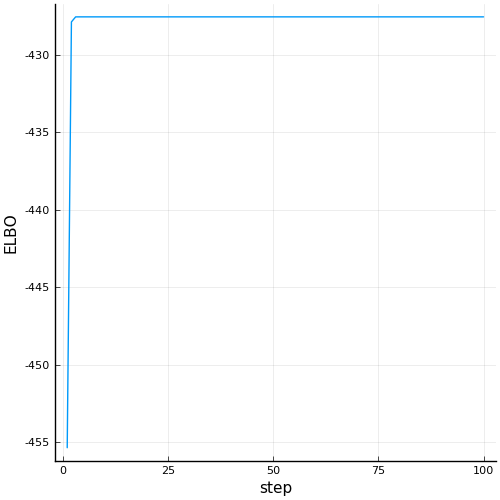

In [154]:
nsteps = 100
elbos = []

validrate = 3
for i = 1:nsteps
    for param in getconjugateparams(model)
        accstats = X |> param.accumulator
        update!(param.posterior, naturalparam(param.prior) + accstats)
    end

    # This is just for monitoring, not actually needed for training.
    push!(elbos, elbo(model, X))   
end

ptraining = plot(
    1:nsteps, elbos,
    size=(500, 500),
    xlabel="step",
    ylabel="ELBO",
    legend=false
)

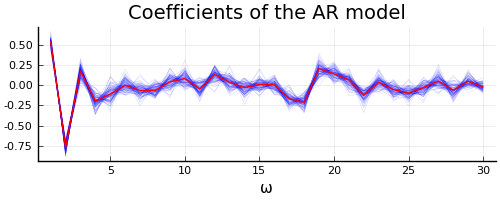

In [155]:
function sample(μ, Σ, N::Int)
    C = cholesky(Σ)
    μ .+ C.L * randn(length(μ), N)
end

gain = sqrt(1 / mean(model.λ.posterior)[1])
filters = sample(model.h.posterior.μ[1:K], 
                 model.h.posterior.Σ[1:K, 1:K], 100)
filters = reverse(filters, dims=1)
mfilter = meanfilter(model)

plot(
    title = "Coefficients of the AR model",
    size = (500, 200), 
    legend = false, 
    xlabel = "ω"
)
plot!(filters, alpha = 0.5, width = 0.1, color = "blue")
plot!(meanfilter(model), color = "red")

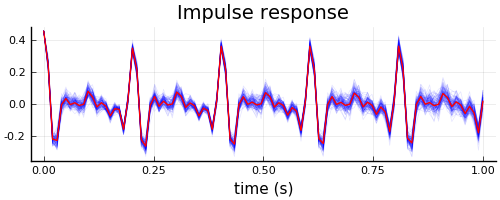

In [156]:
function filter(iir_filter::AbstractVector, gain::Real, x::AbstractVector)
    K = length(iir_filter)
    y = zeros(length(x))
    py = PaddedView(0., y, (1-K:length(x),))
    r_iir_filter = reverse(iir_filter)
    for n in 1:length(x)
        y[n] = sum(py[n-K:n-1] .* r_iir_filter) .+ gain * x[n]
    end
    return y
end

plot(
    title = "Impulse response",
    size = (500, 200), 
    legend = false, 
    xlabel = "time (s)"
)

# Impulse signal.
nperiod = 1
δ = zeros(srate * nperiod)
δ[1] = 1
# δ = randn(srate * nperiod)

for i in 1:size(filters)[2]
    plot!(range(0, nperiod, length=srate * nperiod),
          filter(filters[:, i], gain, δ), 
          width = 0.5, alpha = 0.1, color = "blue")
end
plot!(range(0, nperiod, length=srate * nperiod), 
      filter(mfilter, gain, δ), color = "red")

In [157]:
function H(a::AbstractVector, z_n::Complex{<:AbstractFloat}, 
           gain::Real = 1)
    z = [z_n^-k for k in 1:length(a)]
    return  gain / (1. - dot(z, a))
end

function powerspectrum(iir_filter, gain, srate, resolution=1000)
    nyquist = srate / 2
    fs = Vector(range(0, srate/2, length=resolution))
    fs_norm = fs ./ srate 
    spectrum = [H(iir_filter, exp(f * 2π * im), gain) for f in fs_norm]
    fs, (abs.(spectrum)).^2
end

powerspectrum (generic function with 2 methods)

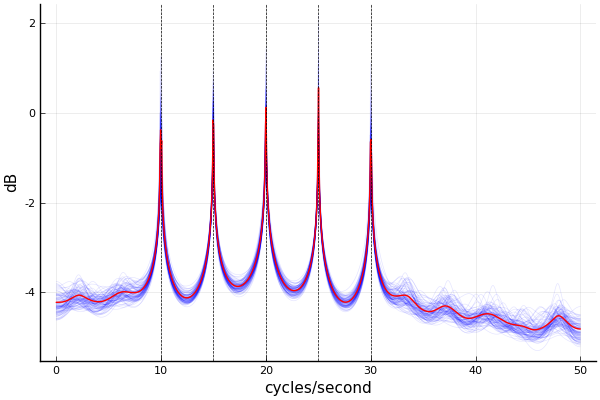

In [158]:
plot(
    xlabel = "cycles/second",
    ylabel = "dB",
    legend = false
)

mfs, mpspec = powerspectrum(mfilter, gain, srate)
pspecmax = maximum(mpspec)
for i in 1:size(filters)[2]
    fs, pspec = powerspectrum(filters[:, i], gain, srate)
    plot!(fs, log10.(pspec ./ pspecmax), 
          width = 0.5, alpha = 0.1, color = "blue")
end


avg_pspec = sum(hcat([powerspectrum(filters[:, i], gain, srate)[2]
                      for i in 1:size(filters)[2]]...), dims=2) 
avg_pspec /= size(filters)[2]
#println(s(avg_pspec))
plot!(mfs, log10.(avg_pspec ./ pspecmax), color = "red")

vline!([wave.freq / 2π for wave in waves], 
       color = "black", width = 0.5, linestyle = :dash) 